<a href="https://colab.research.google.com/github/Yustira/crowd-counting/blob/master/crowd_counting_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crowd Counting Prediction
This notebook is used for prediction only

## Load the imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

import scipy
from scipy import spatial
from scipy import ndimage

import tensorflow as tf
import keras
from keras.layers import Conv2D, Average, MaxPooling2D, Flatten,concatenate, Input, Dense, UpSampling2D, Conv2DTranspose, ReLU, Activation, BatchNormalization,Lambda
from keras.models import Model
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.optimizers import Adam, Nadam
from keras.applications import vgg16
import keras.backend as K

Using TensorFlow backend.


## Load Dataset

### Colab Only

Install PyDrive

In [2]:
!pip install PyDrive

Google Drive Authentication

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Download the file from the link

In [5]:
IMAGE_FILE_ID = "1JSePG9tzuZ6o-roWXjAH71xTxTqVwjnP"
downloaded = drive.CreateFile({'id':IMAGE_FILE_ID})
downloaded.GetContentFile('images.npy')        

In [ ]:
IMAGE_GT_FILE_ID = "1F8MSiZ974Hta6gZcex9DFvGwbhA2u3s8"
downloaded = drive.CreateFile({'id':IMAGE_GT_FILE_ID})
downloaded.GetContentFile('images_gt.npy') 

In [6]:
IMAGE_DENSITY_FILE_ID = "1-1JXmD6sumzJcATFQzm9Yq7CCDZ2K7cT"
downloaded = drive.CreateFile({'id':IMAGE_DENSITY_FILE_ID})
downloaded.GetContentFile('images_density.npy') 

### Load dataset from file

In [7]:
images=np.load('images.npy')
# images_gt=np.load('images_gt.npy',allow_pickle=True)
images_density=np.load('images_density.npy')
# images=images/255

## Data Preview

### Images

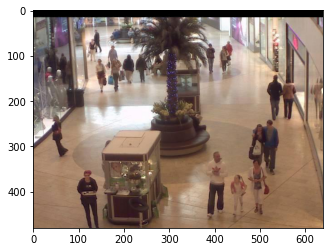

In [ ]:
img=plt.imshow(images[200])

### Images + Density Map

number of people: 26.00


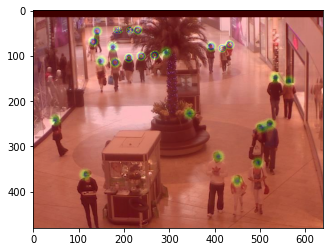

In [ ]:
plt.imshow(images[200])
plt.imshow(images_density[200],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(images_density[200]/1000))

## Model definition

### Import VGG16 as Baseline
Set the input shape for our model\
Creating baseline model with VGG16

In [8]:
size=(96,128)
input_shape=(size[0],size[1],3)
baseline_vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58892288/58889256 [==============================] - 2s 0us/step


### Main Model Architecture

In [9]:
def Crowd_CNN(input_shape=input_shape):
    
    input_flow=Input(input_shape)
    base_filter=8
    
    x_vgg=baseline_vgg.get_layer(index=1)(input_flow)
    for i in range(2,10):
        x_vgg=baseline_vgg.get_layer(index=i)(x_vgg)
        
    
    
    x_1=Conv2D(base_filter*16,9,padding='same',activation='relu')(x_vgg)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(1,1,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    
    
    x_2=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_vgg)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(1,1,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    
    
    x_3=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_vgg)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    
    x_4=Conv2D(base_filter*4,3,padding='same',activation='relu')(x_vgg)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*2,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    
    
    x_conct=concatenate([x_1,x_2,x_3,x_4])
    x_fel=Flatten()(x_conct)
    x_fel=Dense(base_filter*8,activation='relu')(x_fel)
    x_fel=Dense(4,activation='softmax')(x_fel)
    
    x=Lambda(lambda x: x*(1+x_fel))(x_conct)

    
    x=Conv2D(base_filter*2,5,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=concatenate([x,x_conct])
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter*2, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter,1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2D(1,1,padding='same',activation='relu')(x)
    
    model=Model(inputs=input_flow,outputs=x)    
    
    return model
    
    
    
    
    
    
    


### SSIM and Euclidean Loss + Custom MAE metrics

In [10]:
def ssim_loss(y_true, y_pred, c1=0.01**2, c2=0.03**2):
    weights_initial = np.multiply(
        cv2.getGaussianKernel(12, 1.5),
        cv2.getGaussianKernel(16, 1.5).T
    )
    weights_initial = weights_initial.reshape(*weights_initial.shape, 1, 1)
    weights_initial = K.cast(weights_initial, tf.float32)

    mu_F = tf.nn.conv2d(y_pred, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_Y = tf.nn.conv2d(y_true, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_F_mu_Y = tf.multiply(mu_F, mu_Y)
    mu_F_squared = tf.multiply(mu_F, mu_F)
    mu_Y_squared = tf.multiply(mu_Y, mu_Y)

    sigma_F_squared = tf.nn.conv2d(tf.multiply(y_pred, y_pred), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_squared
    sigma_Y_squared = tf.nn.conv2d(tf.multiply(y_true, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_Y_squared
    sigma_F_Y = tf.nn.conv2d(tf.multiply(y_pred, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_mu_Y

    ssim = ((2 * mu_F_mu_Y + c1) * (2 * sigma_F_Y + c2)) / ((mu_F_squared + mu_Y_squared + c1) * (sigma_F_squared + sigma_Y_squared + c2))

    return 1 - tf.reduce_mean(ssim, axis=[1, 2, 3])


def ssim_eucli_loss(y_true, y_pred, alpha=0.0025):
    ssim = ssim_loss(y_true, y_pred)
    eucli = mean_squared_error(y_true, y_pred)
    loss = eucli + alpha * ssim
    return loss

def mae_cnt(labels,preds):
    cnt_label=K.sum(labels)
    cnt_pred=K.sum(preds)
    return K.abs(cnt_label-cnt_pred)

### Define the Model

#### Download the model weight

In [11]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/Yustira/crowd-counting/master/Crowd-CNN \
    -O Crowd-CNN.h5

--2020-06-20 08:37:15--  https://raw.githubusercontent.com/Yustira/crowd-counting/master/Crowd-CNN
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24159968 (23M) [application/octet-stream]
Saving to: ‘Crowd-CNN.h5’

Crowd-CNN.h5        100%[===================>]  23.04M  50.9MB/s    in 0.5s    

2020-06-20 08:37:16 (50.9 MB/s) - ‘Crowd-CNN.h5’ saved [24159968/24159968]



#### Model declaration

In [12]:
lr=1e-5
model=Crowd_CNN()
model.load_weights("Crowd-CNN.h5")
Optimizer=Nadam(lr)
# model.summary()

#### Compile Model

In [13]:
for i in model.layers[:10]:
    i.trainable=False
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

## Create test data and predict

### Data from mall dataset
data will be selected randomly

#### Select random data

In [14]:
test_size = 2

In [45]:
idx_test = np.random.randint(images.shape[0], size=test_size)
idx_test

array([1844, 1360])

In [46]:
X = images[idx_test]/255
y = images_density[idx_test]

#### Selected Image Data Preview

number of people: 30.00


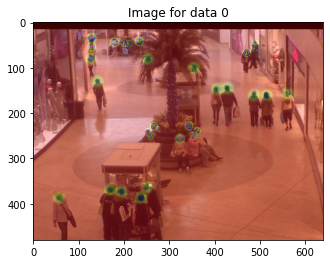

In [38]:
plt.title("Image for data 0")
plt.imshow(X[0])
plt.imshow(y[0],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(y[0]/1000))

number of people: 29.00


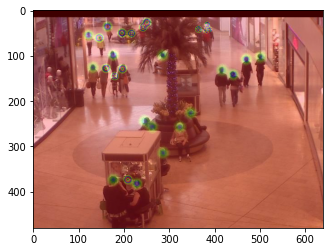

In [39]:
plt.imshow(X[1])
plt.imshow(y[1],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(y[1]/1000))

#### Prediction

In [19]:
def full_eval(x,smooth=False):
    y=np.zeros([480,640])
    for i in range(0,480,size[0]):
        for j in range(0,640,size[1]):
            y[i:i+size[0],j:j+size[1]]+=model.predict(x[:,i:i+size[0],j:j+size[1],:])[0,:,:,0]
    if smooth:
        y=ndimage.filters.gaussian_filter(y, 2, mode='constant')
    return y

In [47]:
y = np.expand_dims(y,-1)
y.shape

In [51]:
X[e:e+1].shape

(1, 480, 640, 3)

(480, 640)
Predicted Number of people: 39.97
Exact Number of people: 41.50


<Figure size 432x288 with 0 Axes>

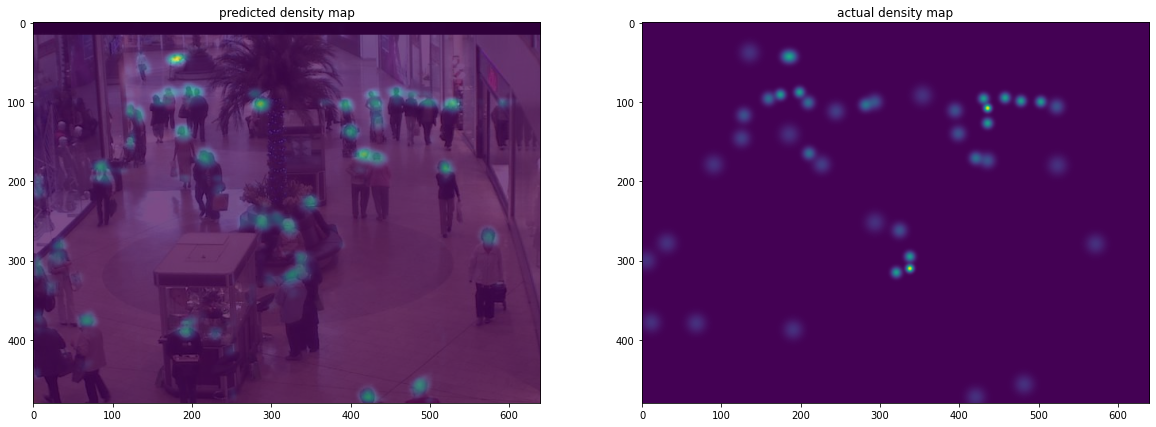

In [48]:
e=0
y_predict=full_eval(X[e:e+1],smooth=True)
print(y_predict.shape)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 

# plot for predicted density map
axarr[0].title.set_text('predicted density map')
axarr[0].imshow(X[e,:,:,:])
axarr[0].imshow(y_predict, alpha=0.7)

# plot for actual density map
axarr[1].title.set_text('actual density map')
axarr[1].imshow(X[e,:,:,:])
axarr[1].imshow(y[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))
print('Exact Number of people: %4.2f' %(np.sum(y[e])/1000))


Predicted Number of people: 28.29
Exact Number of people: 28.00


<Figure size 432x288 with 0 Axes>

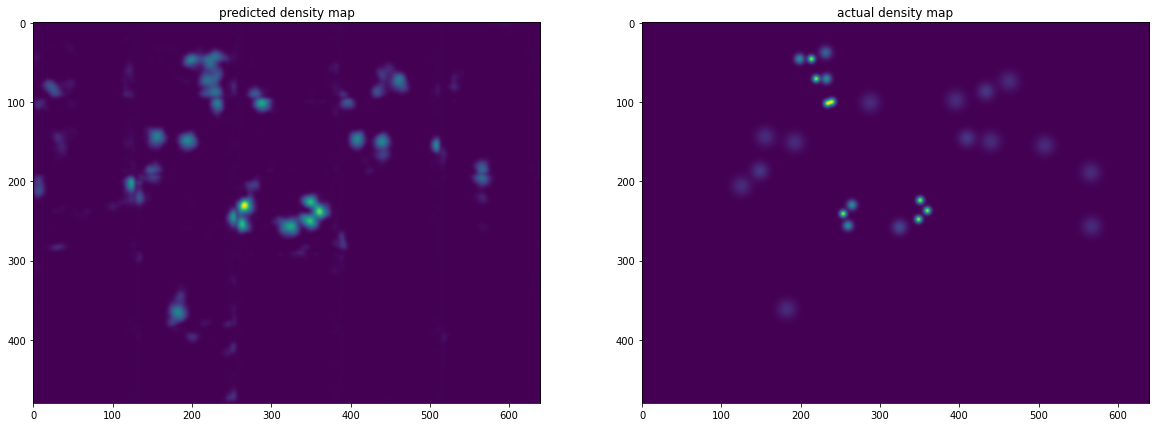

In [49]:
e=1
y_predict=full_eval(X[e:e+1],smooth=True)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 

# plot for predicted density map
axarr[0].title.set_text('predicted density map')
# axarr[0].imshow(X[e,:,:,:])
axarr[0].imshow(y_predict)

# plot for actual density map
axarr[1].title.set_text('actual density map')
# axarr[1].imshow(X[e,:,:,:])
axarr[1].imshow(y[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))
print('Exact Number of people: %4.2f' %(np.sum(y[e])/1000))


In [44]:
for i in range(0, test_size):

  y_predict = full_eval(X[i:i+1],smooth=True)

  print("Prediction for data {}".format(i))
  print('Predicted Number of people: %4.2f' %(np.sum(y_predict)/1000))
  print('Exact Number of people: %4.2f' %(np.sum(y[i])/1000))
  print()


Prediction for data 0
Predicted Number of people: 30.92
Exact Number of people: 30.00

Prediction for data 1
Predicted Number of people: 27.88
Exact Number of people: 29.00



### Data uploaded from user

In [53]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(480, 640))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  images[0] = images[0] / 255

  y_predict = full_eval(images,smooth=True)

  print("\nPrediction for data {}".format(fn))
  print('Predicted Number of people: %4.2f\n' %(np.sum(y_predict)/1000))



Saving shopping_mall.jpg to shopping_mall (1).jpg

Prediction for data shopping_mall.jpg
Predicted Number of people: 39.78

